# Automated Essay Scoring 

### What is this Notebook about?

- This Notebook contains all raw results and experiments done with the various deep learning methods. The output cells contains the results that we got. The whole Notebook may take approximately 5-6 hours. This Notebook contains the following:

* Preprocess data
* Important util methods to be used later
* Deep Learning Model declaration
* Running bert for individual sets
* Running bert for whole dataset
* Running word2vec for individual sets
* Running word2vec for whole dataset

In [2]:
# import important libraries and download data
import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
! git clone https://github.com/Gaurav-Pande/AES_DL.git && mv AES_DL/data .
! pip install transformers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
'git' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
# method to split data into sets
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    
    #for s in range(1,9):
    #    essay_set = data[data["essay_set"] == s]
    #    essay_set.dropna(axis=1, inplace=True)
    #    n, d = essay_set.shape
    #    set_scores = essay_set["domain1_score"]
    #    print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
    #    min_scores.append(set_scores.min())
    #    max_scores.append(set_scores.max())
    #    essay_sets.append(essay_set)
    # return (essay_sets, min_scores, max_scores)
    
    for s in range(1,3):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    return (essay_sets, min_scores, max_scores)

In the below cell, we can see the data we need to operate. We essentially drops the column, we dont need and keep the domain_score only along with essay text.

In [36]:
def dataset_preparation(data_path):
    dataset_path = data_path
    data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")

    #min_scores = [2, 5, 0, 0, 0, 0, 0, 0]
    #max_scores = [30, 40, 3, 3, 4, 4, 30, 60]
    min_scores = [2, 2,]
    max_scores = [10, 10]

    essay_sets, data_min_scores, data_max_scores = split_in_sets(data)

    #set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
    set1, set2 = tuple(essay_sets)
    data.dropna(axis=1, inplace=True)
    data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    set2.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #set3.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #set4.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #set5.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #set6.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #et7.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #set8.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
    #sets = [set1,set2,set3,set4,set5,set6,set7,set8]

    sets = [set1, set2]
    
    return sets, data

data_subject = "bhseng"
data_num = "1"
data_address = "./data/training_set_"+data_subject+data_num+".tsv"
sets, data = dataset_preparation(data_address)
data.head()

Set 1 : Essays =  64 	 Attributes =  6
Set 2 : Essays =  64 	 Attributes =  6


,essay_id,essay_set,essay,domain1_score
0,1,1,"a. 5 Proper nouns: 1. London, 2. Ebenezer Scro...",60
1,2,1,"5 proper nouns London, Ebenezer Scrooge, Bob C...",70
2,3,1,A. Proper nouns : + London Ebenezer scrooge Bo...,55
3,4,1,"a) 5 proper nouns : London, Ebenezer Scrooge, ...",70
4,5,1,5 Proper nouns London was very cold and foggy ...,60


 There are named entity tags as you can see above, which can impact our model. so we need to remove them from the dataframe. So we will extend our stopwords set later on. But first we need to create all possible ner tags.

In [19]:
from sklearn.model_selection import KFold
from preprocess import prepare_data
from utils import *
from utils import build_word2vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#####
#####
# Hyperparameters for word2vec
num_features = 300
min_word_count = 600
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30
#####
####
dataset_path= data_address
# x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

def plot_qwk_scores_all_sets(sets):
  fig = plt.figure()
  ax = plt.subplot(111)
  x = [1,2,3,4,5]
  #set1,set2,set3,set4,set5,set6,set7,set8 = sets
  set1,set2 = sets
  ax.plot(x, set1 , label='set1')
  ax.plot(x, set2, label='set2')
  #ax.plot(x, set3, label='set3')
  #ax.plot(x, set4, label='set4')
  #ax.plot(x, set5, label='set5')
  #ax.plot(x, set6, label='set6')
  #ax.plot(x, set7, label='set7')
  #ax.plot(x, set8, label='set8')
  plt.title('Set wise QWK using BERT for individual sets')
  ax.legend()
  plt.show()

def tsne_plot(model):
	"Creates and TSNE model and plots it"
	labels = []
	tokens = []

	for word in model.wv.vocab:
		tokens.append(model[word])
		labels.append(word)

	tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
	new_values = tsne_model.fit_transform(tokens)

	x = []
	y = []
	for value in new_values:
		x.append(value[0])
		y.append(value[1])

	plt.figure(figsize=(16, 16))
	for i in range(len(x)):
		plt.scatter(x[i], y[i])
		plt.annotate(labels[i],
					 xy=(x[i], y[i]),
					 xytext=(5, 2),
					 textcoords='offset points',
					 ha='right',
					 va='bottom')
	plt.savefig('Graph.png')
	plt.show()

def plot_accuracy_curve(history):
	plt.plot(history.history['loss'])
	plt.plot(history.history['mae'])
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()


def plot_acrchitecture(filename, model):
	from keras.utils import plot_model
	plot_model(model, to_file=str(filename) + '.png')


def build_visualization():
	cv = KFold(n_splits=2, shuffle=True)
	X, y = prepare_data(dataset_path=dataset_path)
	cv_data = cv.split(X)
	results = []
	prediction_list = []
	fold_count =1
	# hyperparameters for word2vec
	most_common_words= []
	for traincv, testcv in cv_data:
		top10 = collections.defaultdict(int)
		print("\n--------Fold {}--------\n".format(fold_count))
		# get the train and test from the dataset.
		X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
		train_essays = X_train['essay']
		#print("y_train",y_train)
		test_essays = X_test['essay']
		#y_train = torch.tensor(y_train,dtype=torch.long)
		train_sentences = []

		for essay in train_essays:
			# get all the sentences from the essay
			train_sentences += essay_to_sentences(essay, remove_stopwords = True)

		# word2vec embedding
		print("Converting sentences to word2vec model")
		model, sorted_dic = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
								  downsampling)

		for k, v in sorted_dic[:10]:
			print("----------most_similar_word_for:" + str(k) + "--------------")
			print(model.wv.most_similar(k))

		top10 = collections.defaultdict(int)
		tsne_plot(model)

In [23]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

Some utility functions declarations needed to convert the raw essay to word list.

In [24]:
import collections
top10 = collections.defaultdict(int)
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    #top10 = collections.defaultdict(int)
    if remove_stopwords:
        stops = stopwords.words("english")
        stops.extend(ner)
        for word in words:
          if word not in stops:
            # words.append(w)
            top10[word]+=1
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

Below we declare the model. here the model is of older version. for running the most recent version please refer to readme, which inputs the model_type as well in terms of hyperparameter.

In [25]:
from keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential,Model, load_model, model_from_config
import keras.backend as K

def get_model(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768, activation='relu', bidirectional = False):
    """Define the model."""
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(Hidden_dim1,return_sequences=return_sequences , dropout=0.4, recurrent_dropout=recurrent_dropout), input_shape=[1, input_size]))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(Hidden_dim1, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=[1, input_size], return_sequences=return_sequences))
        model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

def get_model_CNN(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768,output_dims=10380, activation='relu', bidirectional = False):
    """Define the model."""
    inputs = Input(shape=(768,1))
    x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)
    #Cuts the size of the output in half, maxing over every 2 inputs
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
    x = GlobalMaxPooling1D()(x) 
    outputs = Dense(output_dims, activation='relu')(x)
    model = Model(inputs=inputs, outputs=outputs, name='CNN')
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])
    model.summary()
    return model

Below we will run the model for all sets using BERT


--------SET 1--------


--------Fold 1--------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 1, 800)            3740800   
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4692353 (17.90 MB)
Trainable params: 4692353 (17.90 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

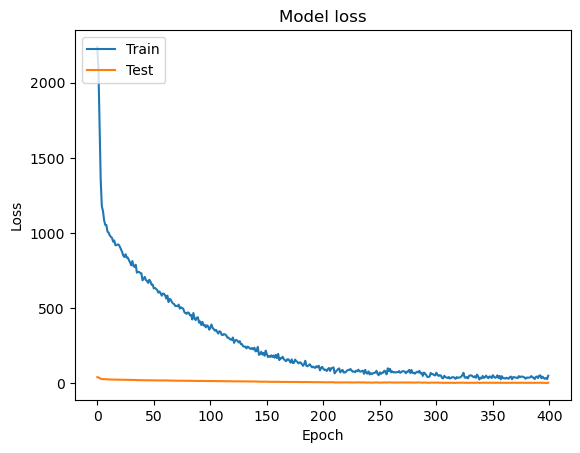

1/1 [==============================] - 1s 541ms/step


Prediction Values: [[62.]
 [52.]
 [60.]
 [62.]
 [ 3.]
 [33.]
 [50.]
 [12.]
 [14.]
 [ 2.]
 [52.]
 [57.]
 [53.]] 

 Test Data Values: [60 60 58 67  2 60 61 13 15  2 63 63 63] 



Kappa Score: 0.7209730171708912 


--------Fold 2--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

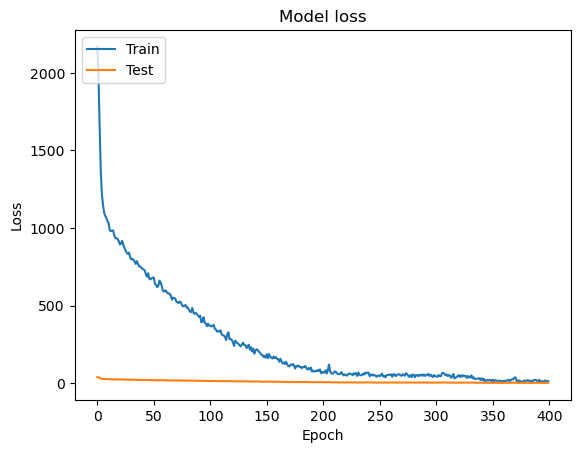

1/1 [==============================] - 1s 527ms/step


Prediction Values: [[62.]
 [50.]
 [26.]
 [17.]
 [14.]
 [60.]
 [60.]
 [57.]
 [ 2.]
 [35.]
 [61.]
 [61.]
 [61.]] 

 Test Data Values: [70 60 25 60 13 61 61 62  2 62 62 63 49] 



Kappa Score: 0.728051391862955 


--------Fold 3--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (

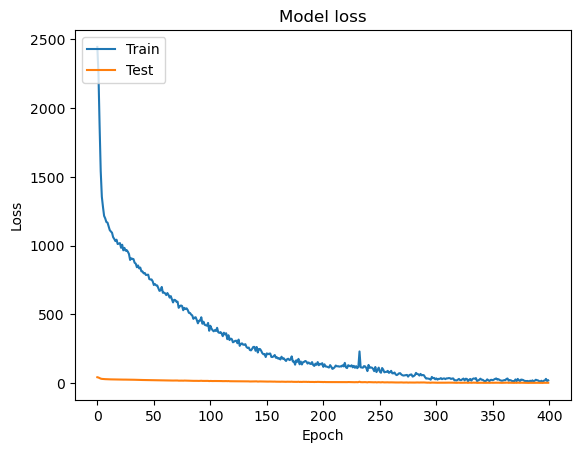

1/1 [==============================] - 1s 534ms/step


Prediction Values: [[63.]
 [54.]
 [54.]
 [26.]
 [60.]
 [21.]
 [57.]
 [11.]
 [53.]
 [60.]
 [53.]
 [ 2.]
 [54.]] 

 Test Data Values: [55 60 60 25 15 11 60 11 21 62 62  2 31] 



Kappa Score: 0.6371385592512118 


--------Fold 4--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

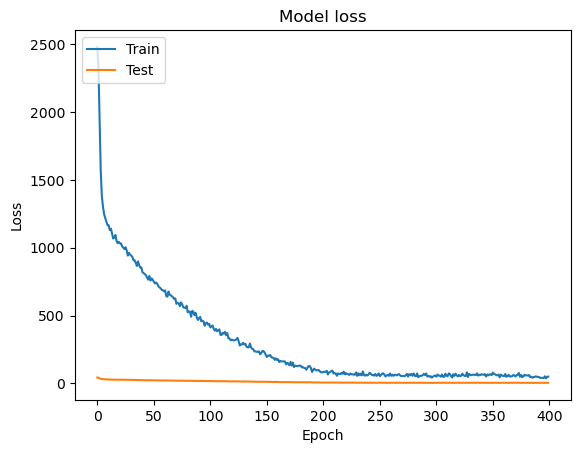

1/1 [==============================] - 1s 541ms/step


Prediction Values: [[59.]
 [59.]
 [58.]
 [58.]
 [31.]
 [52.]
 [10.]
 [58.]
 [39.]
 [ 2.]
 [ 2.]
 [58.]
 [56.]] 

 Test Data Values: [70 60 30 30 33 61 11 61 19  2  2 27 48] 



Kappa Score: 0.6794298199979191 


--------Fold 5--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

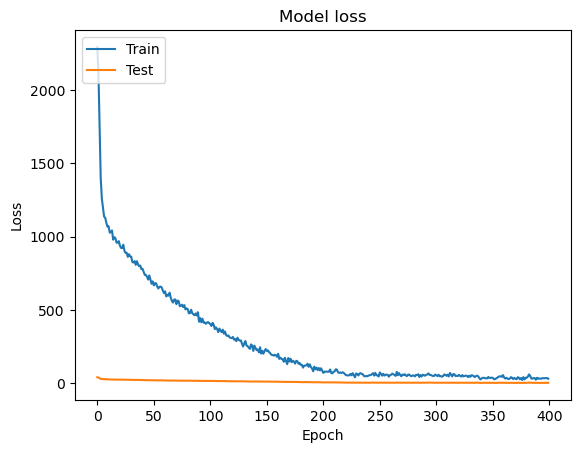

1/1 [==============================] - 1s 521ms/step


Prediction Values: [[62.]
 [34.]
 [14.]
 [12.]
 [49.]
 [63.]
 [62.]
 [ 2.]
 [61.]
 [50.]
 [62.]
 [62.]] 

 Test Data Values: [60 33 15  9 61 70 61  2 62 63 47 47] 



Kappa Score: 0.8182466143977192 

All Sets Score: [[0.7209730171708912, 0.728051391862955, 0.6371385592512118, 0.6794298199979191, 0.8182466143977192]] 

Average kappa score value is : 0.7167678805361393
Train Feature Shape (52, 768)

--------SET 2--------


--------Fold 1--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
             

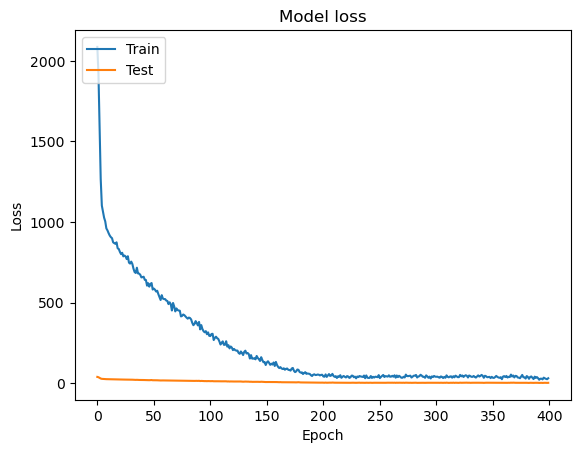

1/1 [==============================] - 1s 583ms/step


Prediction Values: [[56.]
 [ 2.]
 [17.]
 [50.]
 [13.]
 [56.]
 [56.]
 [56.]
 [56.]
 [56.]
 [56.]
 [17.]
 [ 2.]] 

 Test Data Values: [27  2 15 55 12 56 56 58 58 60 60 15  2] 



Kappa Score: 0.9218709171674941 


--------Fold 2--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

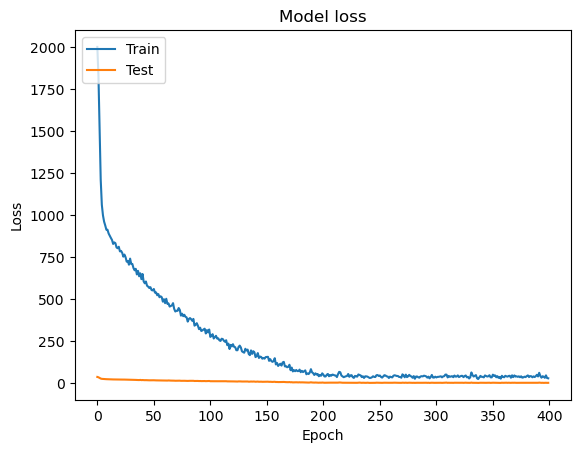

1/1 [==============================] - 1s 513ms/step


Prediction Values: [[55.]
 [56.]
 [54.]
 [12.]
 [55.]
 [54.]
 [25.]
 [55.]
 [51.]
 [55.]
 [12.]
 [55.]
 [55.]] 

 Test Data Values: [49 51 53 13 55 55 25 57 19 58 12 60 60] 



Kappa Score: 0.7289763410634809 


--------Fold 3--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

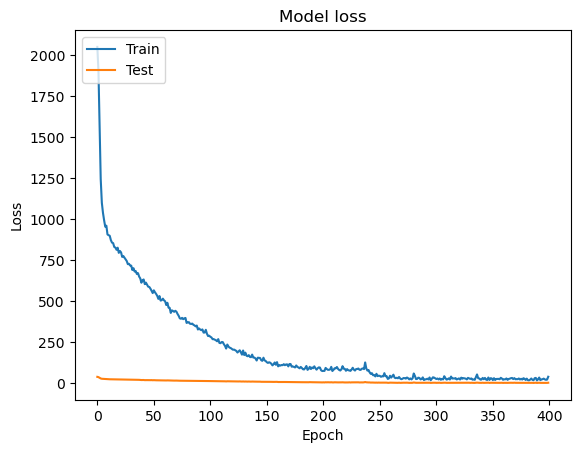

1/1 [==============================] - 2s 2s/step


Prediction Values: [[56.]
 [56.]
 [ 2.]
 [55.]
 [55.]
 [54.]
 [52.]
 [56.]
 [56.]
 [25.]
 [12.]
 [30.]
 [56.]] 

 Test Data Values: [50 53  2 55 33 21 57 70 60 17 11 30 60] 



Kappa Score: 0.756906743877428 


--------Fold 4--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (Non

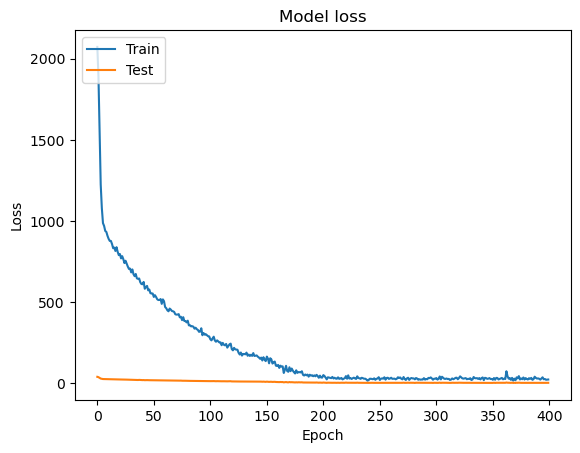

1/1 [==============================] - 1s 535ms/step


Prediction Values: [[56.]
 [57.]
 [57.]
 [55.]
 [ 2.]
 [55.]
 [56.]
 [13.]
 [26.]
 [50.]
 [ 2.]
 [ 2.]
 [57.]] 

 Test Data Values: [53 53 55 56  2 57 58 13 25 33  2  2 70] 



Kappa Score: 0.9116397621070518 


--------Fold 5--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 800)            3740800   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               951296    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               

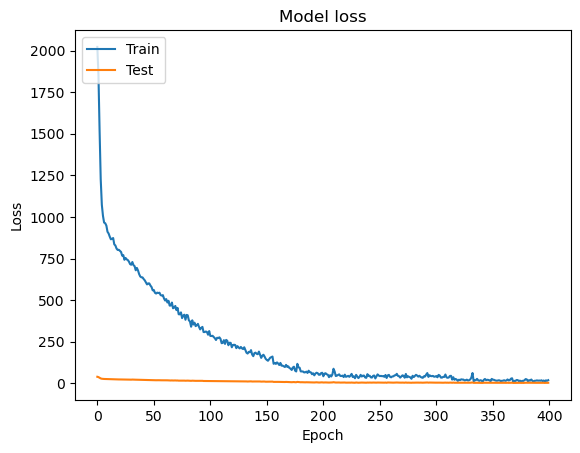

1/1 [==============================] - 1s 519ms/step


Prediction Values: [[48.]
 [55.]
 [42.]
 [10.]
 [28.]
 [57.]
 [55.]
 [ 2.]
 [57.]
 [45.]
 [58.]
 [14.]] 

 Test Data Values: [51 54 55 11 30 56 56  2 57 57 58  9] 



Kappa Score: 0.8745874587458746 

All Sets Score: [[0.7209730171708912, 0.728051391862955, 0.6371385592512118, 0.6794298199979191, 0.8182466143977192], [0.9218709171674941, 0.7289763410634809, 0.756906743877428, 0.9116397621070518, 0.8745874587458746]] 

Average kappa score value is : 0.8387962445922659
Train Feature Shape (52, 768)


In [37]:
## Sets experiment BERT
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
for s in sets:
  print("\n--------SET {}--------\n".format(set_count))
  X = s
  y = s['domain1_score']

  cv = KFold(n_splits=5, shuffle=True)
  cv_data = cv.split(X)
  results = []
  prediction_list = []
  fold_count =1
  cuda = torch.device('cuda')
  # For DistilBERT:
  #model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
  ## Want BERT instead of distilBERT? Uncomment the following line:
  model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)
  with torch.cuda.device(cuda):
    for traincv, testcv in cv_data:
      torch.cuda.empty_cache()
      print("\n--------Fold {}--------\n".format(fold_count))
      # get the train and test from the dataset.
      X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
      train_essays = X_train['essay']
        
      test_essays = X_test['essay']
      #model = model.cuda()
      #y_train = torch.tensor(y_train,dtype=torch.long)
      sentences = []
      tokenize_sentences = []
      train_bert_embeddings = []
      #bert_embedding = BertEmbedding()
      # for essay in train_essays:
      #   # get all the sentences from the essay
      #   sentences += essay_to_sentences(essay, remove_stopwords = True)
      # sentences = pd.Series(sentences)
      # print(train_essays)
        
      tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=512, truncation=True)))
      tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=512, truncation=True)))

      ## train
      max_len = 0
      for i in tokenized_train.values:
        if len(i) > max_len:
          max_len = len(i)
      padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

      attention_mask_train = np.where(padded_train != 0, 1, 0)

      train_input_ids = torch.tensor(padded_train)
      train_attention_mask = torch.tensor(attention_mask_train)
      with torch.no_grad():
        last_hidden_states_train = model(train_input_ids, attention_mask=train_attention_mask)

      train_features = last_hidden_states_train[0][:,0,:].numpy()
      #print("Training Features:", train_features, "\n")

      ## test
      max_len = 0
      for i in tokenized_test.values:
        if len(i) > max_len:
          max_len = len(i)
      padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
      attention_mask_test = np.where(padded_test != 0, 1, 0)
      test_input_ids = torch.tensor(padded_test)  
      test_attention_mask = torch.tensor(attention_mask_test)

      with torch.no_grad():
        last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)

      test_features = last_hidden_states_test[0][:,0,:].numpy()
      train_x,train_y = train_features.shape
      test_x,test_y = test_features.shape

      trainDataVectors = np.reshape(train_features,(train_x,1,train_y))
      testDataVectors = np.reshape(test_features,(test_x,1,test_y))

      lstm_model = get_model(bidirectional=True)
      #lstm_model.fit(trainDataVectors, y_train, batch_size=64, epochs=150)
      history = lstm_model.fit(trainDataVectors, y_train, batch_size=128, epochs=400)
      plot_accuracy_curve(history)
      y_pred = lstm_model.predict(testDataVectors)
      y_pred = np.around(y_pred)
      
      #y_pred.dropna()
      np.nan_to_num(y_pred)
        
      # evaluate the model
      result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
      print("\n\nPrediction Values:", y_pred, "\n\n Test Data Values:",y_test.values, "\n")
      print("\n\nKappa Score: {}".format(result),"\n")
      results.append(result)
      fold_count +=1
      import tensorflow as tf
      tf.keras.backend.clear_session()
       
  all_sets_score.append(results)
  print("All Sets Score:", all_sets_score, "\n")
  print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
  set_count+=1

  print("Train Feature Shape",train_features.shape)
  

In [28]:
lstm_model.save('aeseng-bert-bilstm1.h5')

In [29]:
from keras.models import load_model
# load model from single file
bilstm_model = load_model('aeseng-bert-bilstm1.h5')

In [31]:
import time
import torch
import transformers as ppb
import warnings
import pandas as pd
from keras.models import load_model

warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []

jawabanx1 = 'do not answer.'
jawabanx2 = 'I want a cute kitten for my birthday.'
jawabanx3 = 'My mom`s bread is very delicious'

# creating some sample data
sample = {'set': ['1'],
         'essay': [jawabanx1]}
  
# creating the DataFrame
df = pd.DataFrame(sample)
  
# displaying the DataFrame
# print(df)

df.to_csv('./data/test_bhseng.tsv', sep="\t")

def test_prediction(fileAddress, set):
    dataset_path = fileAddress
    datatest = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")

    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    cuda = torch.device('cuda')
    with torch.cuda.device(cuda):
        test_essays = datatest['essay']
    sentences = []
    tokenize_sentences = []
    train_bert_embeddings = []

    tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))

    max_len = 0
    for i in tokenized_test.values:
        if len(i) > max_len:
            max_len = len(i)
    padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
    attention_mask_test = np.where(padded_test != 0, 1, 0)
    test_input_ids = torch.tensor(padded_test)
    test_attention_mask = torch.tensor(attention_mask_test)

    with torch.no_grad():
        last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)
    test_features = last_hidden_states_test[0][:,0,:].numpy()

    test_x,test_y = test_features.shape

    testDataVectors = np.reshape(test_features,(test_x,1,test_y))

    #lstm_model = get_model(bidirectional=True)
    #modelAddress="aes_model_"+nama_model+set_problem+".h5"
    modelAddress='aeseng-bert-bilstm1.h5'
    bilstm_model.load_weights(modelAddress)
    preds = bilstm_model.predict(testDataVectors)
    predint = int(np.around(preds))
    return predint

predint=test_prediction("./data/test_bhseng.tsv",1)
print("Jawaban Mahasiswa", jawabanx1)
print("Predictions Score:", predint)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 24ms/step
Jawaban Mahasiswa do not answer.
Predictions Score: 4


In [16]:
# x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
def plot_qwk_scores_all_sets():
  fig = plt.figure()
  ax = plt.subplot(111)
  x = [1,2,3,4,5]
  ax.plot(x, set1, label='set1')
  ax.plot(x, set2, label='set2')
  ax.plot(x, set3, label='set3')
  ax.plot(x, set4, label='set4')
  #ax.plot(x, set5, label='set5')
  #ax.plot(x, set6, label='set6')
  #ax.plot(x, set7, label='set7')
  #ax.plot(x, set8, label='set8')
  plt.title('Set wise QWK using BERT for individual sets')
  ax.legend()
  plt.show()